#Re-ranking for diversity of search results
This project focuses on including fairness of exposure based on the
geographical location of Wikipedia articles in the ranking provided
by BM25 using the Pyserini toolkit and Lucene searcher. The issue
of misrepresentation is tackled through re-ranking techniques to
promote diversity. The results are evaluated by different state-of-the-art metrics, such as Precision, Recall, F-score and nDCG. Moreover, two fairness metrics are used to evaluate the fairness compared to the initial BM-25 ranking. 

## Setup the environment

Install Pyserini and other related libraries

In [ ]:
!pip install pyserini
!pip install faiss-cpu
import numpy as np
import pandas as pd
import json
import os
from pyserini.index.lucene import IndexReader
from pyserini.search.lucene import LuceneSearcher

## Downloading the data

Downloading and unzipping the corpus 

Reference : Fair Ranking TREC 2022 https://fair-trec.github.io/docs/Fair_Ranking_2022_Participant_Instructions.pdf

In [ ]:
!wget https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/corpus/trec_corpus_20220301_plain.json.gz -P sample_data/collection
!gzip -d /content/sample_data/collection/trec_corpus_20220301_plain.json.gz 

--2022-12-14 14:44:04--  https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/corpus/trec_corpus_20220301_plain.json.gz
Resolving data.boisestate.edu (data.boisestate.edu)... 132.178.213.65
Connecting to data.boisestate.edu (data.boisestate.edu)|132.178.213.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7677063809 (7.1G) [application/x-gzip]
Saving to: ‘sample_data/collection/trec_corpus_20220301_plain.json.gz’

z                    57%[==========>         ]   4.09G  20.2MB/s    eta 2m 36s 

Create a folder used for storing the converted collection that is used further 
for indexing 

In [ ]:
!mkdir /content/sample_data/collection_converted

Downloading and unzipping fairness categories

In [ ]:
!wget https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/2022/trec_2022_articles_discrete.json.gz
!gzip -d /content/trec_2022_articles_discrete.json.gz

--2022-12-13 18:57:47--  https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/2022/trec_2022_articles_discrete.json.gz
Resolving data.boisestate.edu (data.boisestate.edu)... 132.178.213.65
Connecting to data.boisestate.edu (data.boisestate.edu)|132.178.213.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236812182 (226M) [application/x-gzip]
Saving to: ‘trec_2022_articles_discrete.json.gz’

trec_2022_articles_ 100%[===================>] 225.84M  42.4MB/s    in 5.8s    

2022-12-13 18:57:53 (38.8 MB/s) - ‘trec_2022_articles_discrete.json.gz’ saved [236812182/236812182]



We create a dictionary in which we store the geographical location of the topic for each document id

In [ ]:
fairness_dic = {}
fairness_path = '/content/trec_2022_articles_discrete.json'
with open(fairness_path, encoding="utf-8") as f:
    for i,line in enumerate(f):
      dic = json.loads(line) 
      fairness_dic[dic['page_id']]= dic['page_subcont_regions']

Converting the document collection into an Anserini collection (doing subsampling)

In [ ]:
max_docs_per_file = 1000000
print('Converting collection...')
added_docs = 0
not_added_docs = 0
file_index = 0
output_folder = '/content/sample_data/collection_converted/'
collection_path = '/content/sample_data/collection/trec_corpus_20220301_plain.json'
with open(collection_path, encoding="utf-8") as f:
    for i, line in enumerate(f):
      if i % max_docs_per_file == 0:
          if i > 0:
              output_jsonl_file.close()
          output_path = os.path.join(output_folder, 'docs{:02d}.json'.format(file_index))
          output_jsonl_file = open(output_path,'w', encoding='utf-8', newline='\n')
          file_index += 1
      dic = json.loads(line) 
      try:
        if (len(fairness_dic[dic['id']])>0):
          # here we do the subsampling and we add the document only if there is a georapical location associated
          added_docs += 1
          output_dict= {}
          output_dict['id']= dic['id']
          output_dict['contents'] = dic['plain']
          output_jsonl_file.write(json.dumps(output_dict)+'\n')
      except: 
        not_added_docs +=1

      if i % 100000 == 0:
                print('Converted {} docs in {} files'.format(added_docs, file_index))
    output_jsonl_file.close()

Remove the original files to make room for the index

In [ ]:
!rm -rf /content/sample_data/collection

Generating the index through Pyserini 

In [ ]:
!python -m pyserini.index.lucene -collection JsonCollection -generator DefaultLuceneDocumentGenerator -threads 9 -input /content/sample_data/collection_converted/ -index indexes/trec_2022_documents/ -storePositions -storeDocvectors -storeRaw

2022-12-13 19:12:09,907 INFO  [main] index.IndexCollection (IndexCollection.java:250) - Setting log level to INFO
2022-12-13 19:12:09,911 INFO  [main] index.IndexCollection (IndexCollection.java:253) - Starting indexer...
2022-12-13 19:12:09,911 INFO  [main] index.IndexCollection (IndexCollection.java:254) - ============ Loading Parameters ============
2022-12-13 19:12:09,911 INFO  [main] index.IndexCollection (IndexCollection.java:255) - DocumentCollection path: /content/sample_data/collection_converted/
2022-12-13 19:12:09,912 INFO  [main] index.IndexCollection (IndexCollection.java:256) - CollectionClass: JsonCollection
2022-12-13 19:12:09,912 INFO  [main] index.IndexCollection (IndexCollection.java:257) - Generator: DefaultLuceneDocumentGenerator
2022-12-13 19:12:09,912 INFO  [main] index.IndexCollection (IndexCollection.java:258) - Threads: 9
2022-12-13 19:12:09,913 INFO  [main] index.IndexCollection (IndexCollection.java:259) - Language: en
2022-12-13 19:12:09,913 INFO  [main] in

Clearing some space in the disc


In [ ]:
!rm -rf /content/sample_data/collection_converted
!rm -rf /content/indexes/trec_2022_documents.zip

Downloading the queries file

Note: this file also contains the relevance judgments

In [ ]:
!wget https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/2022/train_topics_meta.jsonl
!head -5 /content/train_topics_meta.jsonl

--2022-12-13 20:05:45--  https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/2022/train_topics_meta.jsonl
Resolving data.boisestate.edu (data.boisestate.edu)... 132.178.213.65
Connecting to data.boisestate.edu (data.boisestate.edu)|132.178.213.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19046885 (18M)
Saving to: ‘train_topics_meta.jsonl’

train_topics_meta.j 100%[===================>]  18.16M  20.7MB/s    in 0.9s    

2022-12-13 20:05:47 (20.7 MB/s) - ‘train_topics_meta.jsonl’ saved [19046885/19046885]

{"id":{"0":84,"1":111,"2":265,"3":323,"4":396,"5":397,"6":403,"7":409,"8":426,"9":475,"10":594,"11":620,"12":666,"13":677,"14":724,"15":726,"16":765,"17":770,"18":785,"19":805,"20":893,"21":956,"22":1055,"23":1102,"24":1225,"25":1319,"26":1343,"27":1368,"28":1371,"29":1412,"30":1457,"31":1509,"32":1565,"33":1625,"34":1630,"35":1656,"36":1715,"37":1773,"38":1970,"39":2006,"40":2213,"41":2272,"42":2365,"43":2429,"44":2465,"45":2741},"keywords":{"0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



63688, 33064045, 33065538, 33065574, 33065588, 33065616, 33069445, 33072651, 33077752, 33084252, 33084503, 33087284, 33087717, 33088552, 33088615, 33088649, 33094876, 33094907, 33095660, 33095765, 33099033, 33099814, 33103106, 33108175, 33108289, 33109257, 33110077, 33114206, 33117381, 33127108, 33132043, 33135838, 33137163, 33138019, 33138129, 33142061, 33148959, 33149203, 33149546, 33149559, 33150271, 33151480, 33151670, 33154437, 33161563, 33162430, 33162782, 33163445, 33163671, 33165400, 33166048, 33166967, 33170991, 33186969, 33187532, 33187565, 33194136, 33199145, 33204812, 33208210, 33208969, 33214156, 33221278, 33226918, 33227692, 33230734, 33230998, 33244851, 33248798, 33249464, 33253166, 33255433, 33258086, 33268364, 33273062, 33276768, 33279678, 33281252, 33290048, 33292758, 33296627, 33312033, 33315008, 33329144, 33331933, 33332800, 33334836, 33352425, 33355511, 33360229, 33363090, 33368967, 33373877, 33378319, 33382821, 33383266, 33384176, 33384913, 33386464, 33393005, 333

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3, 5837876, 5837890, 5837893, 5837900, 5839180, 5839935, 5840120, 5840210, 5840633, 5842015, 5842032, 5842363, 5843971, 5847109, 5848106, 5848110, 5848119, 5849481, 5851067, 5851467, 5851749, 5854150, 5855834, 5857222, 5857582, 5860019, 5863351, 5864002, 5864261, 5864387, 5864833, 5866302, 5866831, 5867145, 5869138, 5871016, 5872482, 5872576, 5873519, 5873967, 5874352, 5874428, 5874734, 5875413, 5876941, 5877247, 5878985, 5884073, 5884697, 5884984, 5885272, 5888918, 5890405, 5891858, 5892290, 5893343, 5895564, 5896319, 5897898, 5898799, 5901274, 5902299, 5902717, 5903104, 5903273, 5909515, 5910082, 5910794, 5912503, 5912783, 5916805, 5916885, 5918589, 5920845, 5921658, 5921686, 5923083, 5925390, 5925402, 5925569, 5926426, 5926882, 5927937, 5928861, 5928926, 5929347, 5930245, 5930321, 5930588, 5931587, 5932077, 5933979, 5935184, 5935894, 5935974, 5936289, 5936395, 5936445, 5937136, 5937539, 5937742, 5937966, 5939773, 5939788, 5939799, 5939805, 5939816, 5940236, 5940634, 5941960, 5942555

In [ ]:
!head -10 /content/trec_2022_articles_discrete.json

{"page_id": 12, "pred_qual": 0.72351444, "qual_cat": "C", "page_countries": [], "page_subcont_regions": [], "source_countries": {"UNK": 52, "United States of America": 41, "United Kingdom": 38, "Canada": 3}, "source_subcont_regions": {"UNK": 52, "Northern America": 44, "Northern Europe": 38}, "gender": [], "occupations": [], "years": [], "num_sitelinks": 142, "relative_pageviews": 1.0, "first_letter": "A", "creation_date": "2001-10-11", "first_letter_category": "a-d", "gender_category": "Unknown", "creation_date_category": "2001-2006", "years_category": "Unknown", "relative_pageviews_category": "High", "num_sitelinks_category": "5+ languages"}
{"page_id": 25, "pred_qual": 0.84996575, "qual_cat": "B", "page_countries": [], "page_subcont_regions": [], "source_countries": {"United Kingdom": 13, "United States of America": 37, "Belgium": 1, "UNK": 159, "Sweden": 2, "France": 1, "International": 1, "Denmark": 1}, "source_subcont_regions": {"Northern Europe": 16, "Northern America": 37, "Wes

Download the file where the relevant documents are stored

In [ ]:
!wget https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/2022/trec_2022_train_reldocs.jsonl

--2022-12-13 23:21:35--  https://data.boisestate.edu/library/Ekstrand/TRECFairRanking/2022/trec_2022_train_reldocs.jsonl
Resolving data.boisestate.edu (data.boisestate.edu)... 132.178.213.65
Connecting to data.boisestate.edu (data.boisestate.edu)|132.178.213.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18018410 (17M)
Saving to: ‘trec_2022_train_reldocs.jsonl’

trec_2022_train_rel 100%[===================>]  17.18M  14.7MB/s    in 1.2s    

2022-12-13 23:21:37 (14.7 MB/s) - ‘trec_2022_train_reldocs.jsonl’ saved [18018410/18018410]



# BM25 Ranking - Lucene Built-In Implementation

Reference: https://github.com/castorini/pyserini/blob/master/docs/usage-interactive-search.md

In [ ]:
searcher = LuceneSearcher("/content/indexes/trec_2022_documents")
searcher.set_bm25(0.8, 0.3)

# Trying out a query 
hits_num = 10
hits2 = searcher.search('Keith Osik', k=hits_num )

# Print the first 10 hits:
for i in range(0, hits_num ):
    print(f'{i+1:2} {hits2[i].docid:15} {hits2[i].score:.5f}')

 1 12148915        11.87000
 2 5679868         10.62540
 3 35242148        9.40630
 4 28459397        9.25080
 5 15489885        9.23880
 6 27427070        9.20800
 7 6046664         9.14090
 8 35575435        8.77040
 9 32564569        7.73820
10 28071093        7.46710


In [ ]:
queries = [] #list where we keep all the queries

f = '/content/train_topics_meta.jsonl'
with open(f, encoding="utf-8", ) as f:
    for i,line in enumerate(f):
      dic = json.loads(line) 
      for key, value in dic['keywords'].items(): 
        value = value.translate({ord(i): None for i in "[' ]"}) #compute the querytext
        nkey = dic['id'].get(key)
        kw = ' '.join(list(value.split(",")))
        
        queries.append({nkey:kw})
print(queries)

[{84: 'cultivated agricultural maize corn fruit wheat agriculture cultivar olive livestock mammal honeybee potato poultry solanum bee cornbread beekeeping honeycrop cherimoya potatoe oleaceae beekeeper cherimola pig honey cornstarch beehive beeline porcine beewolf cornmeal corncob beeswax sugarcane maizegdb cereal chirimuya cattle grain honeycomb umbonata oleae annonaceae hive buffalo chicken sorghum rice cornstalk popcorn strawberry nectar flour plumage rodent vegetable breeding fowl solanaceae cavy olea mammalian pear nutrition hamster cavia banana buffalopedia caviae rabbit polyphenols river botanical citrus polyphenol bubalus freshwater mellifera hen breed insect apidae planting pollen amnuaydechkorn kapi soybean produce agrarian bird rosemary phytochemical corporation agriculturalist oily squash tree patatas cultivation sprout oil duck crossbred phylogenetic egg pandanus crossbreed wildlife goose'}, {111: 'reptile lizard salamander fossil frog prehistoric snake ambystomatidae pale

Here, we run BM25 for the set of queries we downloaded and store the results

In [ ]:
results = []
fairness_statistics_file_path= '/content/stats.txt'
searcher = LuceneSearcher("/content/indexes/trec_2022_documents")

searcher.set_bm25(0.8, 0.3)
hits_num = 10
count = 0
dic_stats = {}
with open(fairness_statistics_file_path,"a", encoding="utf-8", ) as statistics:
  for tup in queries:
    for qid, q in tup.items():
      hits2 = searcher.search(q, k=hits_num)
      count += 1
      for i in range(len(hits2)):
          pos = str(i+1)
          results.append([pos,qid,q,hits2[i].docid,hits2[i].score])

In [ ]:
# check duplicates
check = set()
for res in results:
    if ((res[0], res[1], res[2])) in check:
      pass
    check.add((res[0], res[1], res[2]))

# write results of BM_25 in a file
output_str = "\n".join([str(l[0]) + "\t" + str(l[1])  + "\t" + str(l[3]) + "\t" + str(l[4]) for l in results])
open("results.txt", "w").write(output_str)

14879

Compute BM25 for the queries and keep evidence of the frequency of regions for top-10 

In [ ]:
searcher = LuceneSearcher("/content/indexes/trec_2022_documents")

searcher.set_bm25(0.8, 0.3)
hits_num = 15
count = 0
dic_stats = {}
with open(fairness_statistics_file_path,"a", encoding="utf-8", ) as statistics:
  for tup in queries:
    for qid, q in tup.items():
      print("query text: ",q)
      hits2 = searcher.search(q, k=hits_num)
  
      stats = {'Caribbean':0,'Northern America':0, 'Southern America':0, 'Central America':0, 'Western America':0, 'Eastern America':0, 'Northern Europe':0, 'Western Europe':0, 'Southern Europe':0, 
                'Eastern Europe':0, 'Eastern Asia':0, 'Western Asia':0, 'Northern Asia':0, 'Southern Asia':0, 'Australia and New Zealand':0, 'Southern Africa':0, 'Western Africa':0, 'Northern Africa':0, 'Eastern Africa':0}
      for i in range(0, len(hits2)):
        try:
          geogr_loc_list = fairness_dic[int(hits2[i].docid)]
          for loc_ind in range(len(geogr_loc_list)):
              stats[geogr_loc_list[loc_ind]] += 1

          print(f'{i+1:2} {hits2[i].docid:15} {hits2[i].score:.5f} {geogr_loc_list}') 
      

        except:
          pass
      print("\n")
      dic_stats[q] = stats
    for key in dic_stats.keys():
      statistics.write( q + ' ' + str(dic_stats[key]) + '\n' )
statistics.close()


query text:  cultivated agricultural maize corn fruit wheat agriculture cultivar olive livestock mammal honeybee potato poultry solanum bee cornbread beekeeping honeycrop cherimoya potatoe oleaceae beekeeper cherimola pig honey cornstarch beehive beeline porcine beewolf cornmeal corncob beeswax sugarcane maizegdb cereal chirimuya cattle grain honeycomb umbonata oleae annonaceae hive buffalo chicken sorghum rice cornstalk popcorn strawberry nectar flour plumage rodent vegetable breeding fowl solanaceae cavy olea mammalian pear nutrition hamster cavia banana buffalopedia caviae rabbit polyphenols river botanical citrus polyphenol bubalus freshwater mellifera hen breed insect apidae planting pollen amnuaydechkorn kapi soybean produce agrarian bird rosemary phytochemical corporation agriculturalist oily squash tree patatas cultivation sprout oil duck crossbred phylogenetic egg pandanus crossbreed wildlife goose
 1 22577012        118.69750 ['Southern Europe']
 2 37831564        112.78530 [

# Re-ranking the results based on fairness and relevancy

Define a function that retrieves the top documents between two limits from the ranking computed by using Lucene implementation

In [ ]:
def ranking_top(hits2,n,m):
  """
    input: top ranking stored in hits, n- lower limit of the ranking, m- upper limit of the ranking;
    output: dictionary -> key: The geographical location associated with the article(document) topic ;
                          value: list of tuples, each tuple contains: 1. the position of the article in the ranking;
                                                                      2. it's BM25 score;
                                                                      3. the document id
  """

  hits_num=m 
  category_dict={} #used for region and lists of tuples
  
  for i in range(n, m): #for top ranking between lower limit n and upper limit m; e.g., 1-5 or 6-15
    try:
      geogr_loc_list = fairness_dic[int(hits2[i].docid)]
      
      if geogr_loc_list[0] not in category_dict: 
        category_dict[geogr_loc_list[0]]=[]
        category_dict[geogr_loc_list[0]].append((i+1,hits2[i].score, hits2[i].docid))
      elif geogr_loc_list[0] in category_dict: 
        category_dict[geogr_loc_list[0]].append((i+1,hits2[i].score, hits2[i].docid))
    except:
      pass

  return category_dict

In [ ]:
hits = searcher.search('maize', 20)
r_5 = ranking_top(hits,0,20)
print(r_5)

{'Australia and New Zealand': [(1, 6.436600208282471, '50741902')], 'South America': [(2, 6.3917999267578125, '24931681'), (7, 6.293499946594238, '18400157'), (12, 6.156400203704834, '24550677'), (14, 6.127999782562256, '24932627'), (19, 6.046899795532227, '11252455')], 'Northern America': [(3, 6.387499809265137, '114926'), (4, 6.3734002113342285, '28067086'), (5, 6.3460001945495605, '25393211'), (8, 6.237599849700928, '49640472'), (10, 6.189899921417236, '7435052'), (15, 6.115900039672852, '55188'), (18, 6.073299884796143, '31126376')], 'Eastern Africa': [(6, 6.315999984741211, '14543243'), (9, 6.222400188446045, '2059704'), (11, 6.176199913024902, '2860802')], 'Central America': [(13, 6.133299827575684, '46831763'), (16, 6.114699840545654, '2394891'), (17, 6.0995001792907715, '614716'), (20, 6.028600215911865, '5011479')]}


Find the most represented region

In [ ]:
def biased_region(ranking):
  """
   input: top 5 ranking
   output: dictionary -> key: The geographical location associated with the article(document) topic ;
                         value: list of tuples, each tuple contains: 1. the position of the article from which the region start to be
                                                                        overrepresented(e.g the third, the fourth or the fifth)
                                                                     2. it's BM25 score
                                                                     3. the document id
  """
  most_rep=[] #store the regions that are the most represented
  for k,v in ranking.items():
    if len(v)>=3: #if a region appear more than 2 times in the ranking, it is considered a bias
      for i in range(2,len(v)): 
        most_rep.append((k,v[i]))

  return most_rep

In [ ]:
hits = searcher.search('maize', 5)
r_5= ranking_top(hits,0,5)
r= biased_region(r_5)
print(r_5)

{'Australia and New Zealand': [(1, 6.436600208282471, '50741902')], 'South America': [(2, 6.3917999267578125, '24931681')], 'Northern America': [(3, 6.387499809265137, '114926'), (4, 6.3734002113342285, '28067086'), (5, 6.3460001945495605, '25393211')]}


Calculate average_bm to keep track of the relevancy of the potential candidates for re-ranking

> NOTE:


*   For top5 we need average_bm top5-15
*   For top10 we need average_bm top10-20

In [ ]:
def average_bm_top_n(ranking_n_m):
  sum=0
  bm_scores=[] #store the bm25 scores
  for region,doc_list in ranking_n_m.items():
      for i in range(len(doc_list)):
        doc = doc_list[i]
        score = doc[1]
        bm_scores.append(score)
  if len(bm_scores)>0:
    for i in bm_scores:
      sum = sum + i
    average_bm=sum/len(bm_scores)
  return average_bm

average_bm_top_n(r_5)

6.387060070037842

Look for eligible documents for swapping 

Count the appearance of regions in the ranking in order to keep track of the new region to not become a bias itself 

In [ ]:
def count_appearance(region,ranking):
  for key, val in ranking.items():
      if key == region:
        return len(val)
  return 0

Select the eligible candidate

In [ ]:
def eligible_candidate_for_q( bias_region,  ranking_6_15, rank_5):
  """
  input:1.list of tuples, each tuple contains the biased region, and another tuple that contains the position of the document in the ranking, its BM25 score and the docid
        2.the ranking we are searching the eligible candidate for swapping
        3.the ranking we are searching for the bias
  output: list of tuples with the same format but containing the eligible candidates
  """

  eligible=[]
  if len(bias_region)>0:
    for region, doc_list in ranking_6_15.items(): 
      region_count = 0
      count_region_in_eligible = len(doc_list)
      for  doc in doc_list:
          region_count += 1
          if (region_count + count_appearance(region, rank_5)<3):
              # We need to make sure to not add to the eligible list too many documents
              # and to make sure that the fairness category of the candidate isn't already 
              # present more than 2 times in the top_5
              position = doc[0]
              score = doc[1]
              id = doc[2]
              if region != bias_region[0][0]:
                  if (score > average_bm_top_n(ranking_6_15) ):
                    eligible.append((region, (position,score, id)))
  return eligible


hits = searcher.search('cosmologist', 20)
elig = eligible_candidate_for_q(biased_region(ranking_top(hits,0,5)), ranking_top(hits, 6,15), ranking_top(hits,0,5))
print(elig)

[('Eastern Europe', (9, 7.224100112915039, '42244963')), ('Southern Europe', (10, 7.18310022354126, '31285910'))]


In [ ]:
def extract_ranking_top_n_m(n,m, ranking):
   """
   input: n-lower limit of the ranking, m-upper limit of the ranking, a ranking with swaps, differents from BM25 builtin ranking
   output: the ranking between limits
   """
   new_ranking = {}
   for region,doc_list in ranking.items():
      for i in range(len(doc_list)):
        doc = doc_list[i]
        score = doc[1]
        position = doc[0]
        id = doc[2]
        if (position>n and position<m):
             if region not in new_ranking.keys(): 
                  new_ranking[region] = []
             new_ranking[region].append((position, score, id))
   return new_ranking

hits = searcher.search('cosmologist', 20)
top_20 = ranking_top(hits,0,20)
extract_ranking_top_n_m(0,5,top_20)

{'Northern America': [(1, 7.710299968719482, '4352469'),
  (2, 7.62939977645874, '23704170'),
  (3, 7.5447998046875, '726376'),
  (4, 7.453999996185303, '42912557')]}

implement swapping

In [ ]:
def swapping_q_top5(bias, eligible,ranking):
    """
    input: list of biased regions, list of eligible candidates, ranking top5
    output: re-ranked top5
    """
    if len(bias)==0 or len(eligible)==0:
      pass
    else:
      if len(bias)<len(eligible):
        print('eligible > bias ')
        for i in range(len(bias)):
            for k,v in ranking.items():
              for j in range(len(v)):
                if v[j] == bias[i][1] and k==bias[i][0]:
                    print('swapping element', v[j])
                    v[j]=(eligible[i][1][0], v[j][1], v[j][2])
                if v[j] == eligible[i][1] and k==eligible[i][0]:
                    print('swapping element', v[j])
                    v[j]=(bias[i][1][0], v[j][1], v[j][2])
                 
      elif len(bias)==len(eligible):
        for i in range(len(bias)):
          print('eligible = bias ')
          for k,v in ranking.items():
            for j in range(len(v)):
              if v[j] == bias[i][1] and k==bias[i][0]:
                 print('swapping element', v[j])
                 v[j]=(eligible[i][1][0], v[j][1], v[j][2])
              if v[j] == eligible[i][1] and k==eligible[i][0]:
                 print('swapping element', v[j])
                 v[j]=(bias[i][1][0], v[j][1], v[j][2])     
      else:
        # in this case, the size biased region is greater than the length of eligible candidates
        # so, this is the toy case:
        # bias = (3, 4, 5)
        # eligible = (6, 7)
        # we want to replace doc 4 with 6 and doc 5 with 7
        # so, we reverse both eligible so that it is (7,6) and bias so that it is (5,4,3)
        # and perform len(eligible) = 2 swaps between the first and second component
        # of the bias and eligible. 
        print('eligible <  bias ')
        bias.reverse()
        eligible.reverse()
        for i in range(len(eligible)):
          #if count_appearance(eligible[i][0],rank_5)==0:
          for k,v in ranking.items():
            for j in range(len(v)):
                if v[j] == bias[i][1] and k==bias[i][0]:
                    print('swapping element', v[j])
                    v[j]=(eligible[i][1][0], v[j][1], v[j][2])
                if v[j] == eligible[i][1] and k==eligible[i][0]:
                    print('swapping element', v[j])
                    v[j]=(bias[i][1][0], v[j][1], v[j][2])
    return ranking


Now, we implement the re-ranking over the set of all the queries

In [ ]:
with open('/content/results_2.txt',"a", encoding="utf-8", ) as results_rerank:
  count = 0
  for query in queries:
    for qid in query.keys():
    
        print('qid', qid)
        keyword = query[qid]
        print('keyword', keyword)
        count += 1
        
        results = []
        hits = searcher.search(keyword, 20)
        
        top_20 = ranking_top(hits,0,20)
        print('ranking', top_20)
        top_5 = ranking_top(hits, 0,5)
        top_6_15 = ranking_top(hits, 5,15)

        bias_region = biased_region(top_5)
        if (len(bias_region)>0):
          print('biased_region', bias_region)

        eligible_candidates = eligible_candidate_for_q(bias_region, top_6_15, top_5)
        if (len(eligible_candidates)>0):
           print('eligible_candidates', eligible_candidates)
        top_20 = swapping_q_top5(bias_region, eligible_candidates, top_20)
        print('new_ranking after 1st swap', top_20)

        top_6_10 = extract_ranking_top_n_m( 5, 11, top_20)
        top_11_20 = extract_ranking_top_n_m(10, 21, top_20)

        bias_region = biased_region(top_6_10)
        if (len(bias_region)>0):
          print('biased_region for 2nd swap', bias_region)

        eligible_candidates = eligible_candidate_for_q(bias_region, top_11_20, top_6_10)
        if (len(eligible_candidates)>0):
          print('eligible_candidates for 2nd swap', eligible_candidates)
        top_20 = swapping_q_top5(bias_region, eligible_candidates, top_20)
        print('new_ranking after 2nd swap', top_20)

        for reg, doc_list in top_20.items():
            for doc in doc_list:
                pos = doc[0]
                score = doc[1]
                id = doc[2]
                if (pos<11):
                    results_rerank.write(str(pos) + '\t' + str(qid)  + '\t'+ str(id) + '\t'+ str(score)+'\n')
results_rerank.close()


# Evaluating the retrieval systems

In [ ]:
import json
input_file_path = "/content/trec_2022_articles_discrete.json"
c_a = 0
with open(input_file_path) as input_file:
    for i, line in zip(range(1000000), input_file):
        line_d = json.loads(line)
        c_a += len(line_d["page_countries"])>0
print(c_a)

585633


In [ ]:
def parse_results_line(line):
    sline = line.split('\t')
    position = int(sline[0])
    query = int(sline[1])
    document = int(sline[2])
    score = float(sline[3])
    return position, query, document, score

In [ ]:
f = '/content/trec_2022_train_reldocs.jsonl'
dc = {}
with open(f, encoding="utf-8", ) as f:
    for i,line in enumerate(f):
      dic = json.loads(line) 
      id = dic['id']
      title = dic['title']
      rel_docs = dic['rel_docs'] 
      dc.update({id: rel_docs})

In [ ]:
lst = []
count = 0
with open('results.txt', 'r') as qrel_file:
  for i in qrel_file: 
    count += 1
    position, query, document, score = parse_results_line(str(i))
    if query in dc:
        rel_docs = dc.get(query)
        tot_rel_docs = len(rel_docs) 
        result = rel_docs.count(document)
       
        # Retrieving the fairness cathegory and parsing it to string format
        fair_cat = ','.join(fairness_dic[document])
        
        if result > 0:
          p = (query,document,score,1, tot_rel_docs, position, fair_cat)
          lst.append(p)
        else:
          p = (query,document,score,0, tot_rel_docs, position, fair_cat)
          lst.append(p)

In [ ]:
data = pd.DataFrame(lst, columns =['query',  'document', 'score',  'relevancy', 'tot_rel_docs', 'position', 'geogr_location'])
top5 = data[data['position']<6]
top5.head()

query  document       score  relevancy  tot_rel_docs  position  \
0     84  22577012  118.697502          1          7421         1   
1     84  37831564  112.785301          1          7421         2   
2     84  21393571  112.027603          1          7421         3   
3     84  22576931  109.036598          1          7421         4   
4     84   1913091  106.345497          0          7421         5   

    geogr_location  
0  Southern Europe  
1  Central America  
2    South America  
3   Eastern Europe  
4    South America

In [ ]:
def DCG (top_10_keyword):
  
    """
      Computes the discounted cumulative gain
    """
    dcg = (top_10_keyword['relevancy'])/ (np.log2(1 + top_10_keyword['position']))
    return dcg.sum()

In [ ]:
def NDCG( top_10_keyword):
  
    """
      Computes the normalized discounted cumulative gain
    """
    ndcg = 0
    # Retrieving ideal ranking (i.e: the relevant documents in the top 10 are in the first positions)
    top_10_sorted = top_10_keyword.sort_values(by = 'relevancy', ascending = False)
    sorted_array_positions = range(1,len(top_10_keyword)+1)
    top_10_sorted['position'] = sorted_array_positions
    # Computes idcg
    idcg = DCG(top_10_sorted)
    if (idcg!=0):
        ndcg = float(DCG(top_10_keyword)/idcg)
    return ndcg

In [ ]:
def retrieve_labels(top_10_keyword):
  
  """
    Returns the list of values of the fairness category in the top_10 ranking
  """
  labels = list(top_10_keyword['geogr_location'].unique())
  list_lab = []
  index_to_remove = []
  for _ in range(len(labels)):
    # Check if lab is a list
      lab = labels[_]
      if ',' in lab:
          L = lab.split(',')
          index_to_remove.append(lab)
          for l in L:
            list_lab.append(l) 
  for i in index_to_remove:
      labels.remove(i)
  for l in list_lab:
      labels.append(l)
  #print(labels)
  return np.array(labels)

In [ ]:
def compute_attention_per_category(top_10_keyword, label):
  
   """
      Returns the attention given to a related category
   """
   attention = 0
   docs_with_label = top_10_keyword[top_10_keyword['geogr_location'].str.contains(label)]
   attention = 1 / (np.log2(1 + docs_with_label['position']))
   
   return attention.sum()

In [ ]:
def cumulative_attention(top_10_keyword):

    """
      Returns the difference between the attention of the most represented category
      and the attention of the least represented category
    """
    
    geogr_locations = retrieve_labels(top_10_keyword)
    attention = []
    for loc in geogr_locations:
        attention.append(compute_attention_per_category(top_10_keyword, loc))
   
    return attention

In [ ]:
def pairwise_fairness_loss(attention, N):

    """
      Retrieves the sum of the pairwise differences between the attention 
      of all the fairness labels in a ranking
    """
    pairwise_attention = []
    count_j = 0
    count_i = 0
    for j in range(len(attention)):
       count_j += 1
       count_i = 0
       for i in range(j+1, len(attention)):
            count_i += 1
            pairwise_attention.append(abs(attention[j]-attention[i]))

    if (len(pairwise_attention)!=0):
      mean =  sum(pairwise_attention)/len(pairwise_attention)
    else:
      mean = attention

    return mean

In [ ]:
def greatest_fairness_loss(attention):
  """
      Returns the difference between the attention of the most represented category
      and the attention of the least represented category
    """
  g_f_l = max(attention)-min(attention)
  return g_f_l

In [ ]:
def number_of_fairness_categories(top_10_keyword):
    """
      Basic fairness metric that retrieves the number of fairness labels present in a top 10 
    """
    tot_fair_categories = retrieve_labels(top_10_keyword).size
    print(tot_fair_categories)
    return tot_fair_categories

Now, we will compute the values of the evaluation metrics defined above for the top-10

In [ ]:
df = data.groupby(['query']).agg({'score':'mean', 
                         'relevancy': 'sum', 
                          'position': 'mean',
                         'tot_rel_docs':'mean',
                         'document': 'count'})

Below, we compute precision, recall and f-score for each query

In [ ]:
df['precision'] = df['relevancy'] / df['document']
df['recall'] = df['relevancy'] / df['tot_rel_docs'] 
df['f_score'] = (2*df['precision']*df['recall'])/(df['precision']+df['recall'])

Below we compute the other metrics per query and store them in a list

In [ ]:
ndcg = []
dcg = []
fairness_metric_total = []
fairness_metric_pairwise = []
tot_fair_categories = []
list_keywords = data['query']
for query in list_keywords:
    top_10_keyword = data[data['query'] == query]
    count = 0
    
    dcg.append(DCG(top_10_keyword))
    ndcg.append(NDCG(top_10_keyword))
    attention = cumulative_attention(top_10_keyword)
    N_fair_labels = number_of_fairness_categories(top_10_keyword)
    fairness_metric_total.append(greatest_fairness_loss(attention))
    pa = pairwise_fairness_loss(attention, N_fair_labels)
    fairness_metric_pairwise.append(pairwise_fairness_loss(attention, N_fair_labels))
    tot_fair_categories.append(number_of_fairness_categories(top_10_keyword))

Now, we average the results per query.

In [ ]:
top_10_ndcg = (sum(ndcg)/len(ndcg))
dcg_mean = (sum(dcg)/len(dcg))
precision_mean = df['precision'].mean()
recall_mean = df['recall'].mean()
f_score_mean =df['f_score'].mean()
fairness_metric_pair = (sum(fairness_metric_pairwise)/len(fairness_metric_pairwise))
fairness_metric_tot = (sum(tot_fair_categories)/len(tot_fair_categories))
print(top_10_ndcg)
print(fairness_metric_pair)
print(fairness_metric_tot)
print(recall_mean)
print(precision_mean)
print(f_score_mean)

"""
SCORES FOR RANKING TOP 10
0.8108956649874547
[1.60330972]
5.326086956521739
0.0003516115278503663
0.6195652173913043
0.000718049093210132

SCORES FOR RE RANKING TOP 10
0.8126126800019875
[1.30659688]
5.760869565217392
0.0003287860722931677
0.6065217391304347
0.0006714615040138384
"""

Now, we extract the top5 from the dataset and repeat the steps below in order to get the evaluation metrics at cutoff 5

In [ ]:
df_5 = top5.groupby(['query']).agg({'score':'mean', 
                         'relevancy': 'sum', 
                          'position': 'mean',
                         'tot_rel_docs':'mean',
                         'document': 'count'})
df_5['precision'] = df_5['relevancy'] / df_5['document']
df_5['recall'] = df_5['relevancy'] / df_5['tot_rel_docs'] 
df_5['f_score'] = (2*df_5['precision']*df_5['recall'])/(df_5['precision']+df_5['recall'])

In [ ]:
ndcg_5= []
dcg_5 = []
fairness_metric_total_5= []
fairness_metric_pairwise_5 = []
tot_fair_categories_5 = []
list_keywords = data['query']
for query in list_keywords:
    top_5_keyword = top5[top5['query'] == query]
    count = 0
    
    dcg_5.append(DCG(top_5_keyword))
    ndcg_5.append(NDCG(top_5_keyword))
    attention_5 = cumulative_attention(top_5_keyword)
    N_fair_labels_5 = number_of_fairness_categories(top_5_keyword)
    fairness_metric_total_5.append(greatest_fairness_loss(attention_5))
    fairness_metric_pairwise_5.append(pairwise_fairness_loss(attention_5, N_fair_labels_5))
    tot_fair_categories_5.append(number_of_fairness_categories(top_5_keyword))

In [ ]:
top_5_ndcg = (sum(ndcg_5)/len(ndcg_5))
dcg_mean_5 = (sum(dcg_5)/len(dcg_5))
precision_mean_5= df_5['precision'].mean()
recall_mean_5= df_5['recall'].mean()
f_score_mean_5 =df_5['f_score'].mean()
fairness_metric_pair_5 = (sum(fairness_metric_pairwise_5)/len(fairness_metric_pairwise_5))
fairness_metric_tot_5 = (sum(tot_fair_categories_5)/len(tot_fair_categories_5))
print(top_5_ndcg)
print(fairness_metric_pair_5)
print(fairness_metric_tot_5)
print(recall_mean_5)
print(precision_mean_5)
print(f_score_mean_5)
"""
SCORES FOR TOP 5 RANKING
0.7843448091268951
[1.3326771]
3.3260869565217392
0.00018228563706140267
0.6391304347826087
0.00039907560909973385

SCORES FOR TOP 5 RE RANKING 
0.7893541289938125
[1.06076065]
4.0
0.0001795284006922572
0.6434782608695653
0.0003839058740116808
"""

#Distribution Plot



In [ ]:
lst = []
with open('stats.txt', 'r') as qrel_file:
  for i in qrel_file:
   l = i.split("{",1)
   ls = "{" + l[1]
   Dict = eval(ls)
   lst.append(Dict)

In [ ]:
df_countries = pd.DataFrame.from_dict(lst)

In [ ]:
df_countries.sum()

Caribbean                     143
Northern America             6704
Southern America                0
Central America               165
Western America                 0
Eastern America                 0
Northern Europe              2181
Western Europe               1665
Southern Europe               615
Eastern Europe                722
Eastern Asia                  974
Western Asia                 1003
Northern Asia                   0
Southern Asia                 841
Australia and New Zealand     663
Southern Africa               145
Western Africa                101
Northern Africa               298
Eastern Africa                155
dtype: int64

In [ ]:
labels = ['Caribbean','Northern-America', 'Southern-America', 'Central-America', 'Western-America', 'Eastern-America', 'Northern-Europe', 'Western-Europe', 'Southern-Europe', 
             'Eastern-Europe', 'Eastern-Asia', 'Western-Asia', 'Northern-Asia', 'Southern-Asia', 'Australia-and-New Zealand', 'Southern-Africa', 'Western-Africa', 'Northern-Africa', 'Eastern-Africa']

bars = ['C', 'AUS/NZ','N-AM', 'S-AM', 'W-AM', 'E-AM', 'C-AM', 'N-EU', 'S-EU', 'W-EU', 'E-EU', 'N-AS', 'S-AS', 'W-AS', 'E-AS', 'N-AF', 'S-AF', 'W-AF', 'E-AF']

In [ ]:
score = [143,663,6704,0,0,0,165,2181,615,1665,722,0,841,1003,974,298,145,101,155]

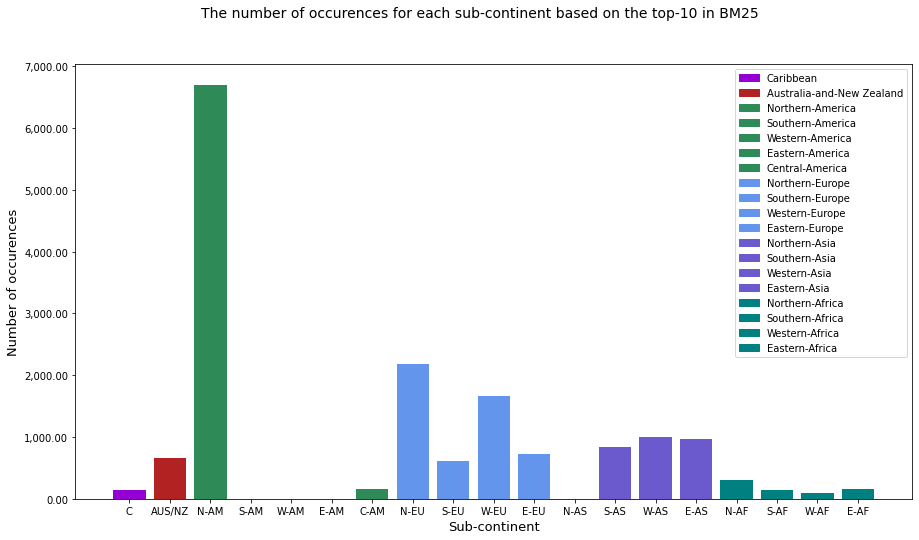

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.gcf().set_size_inches(15, 8)
# Create bars
colors = {'Caribbean':'darkviolet', 'Australia-and-New Zealand':'firebrick','Northern-America':'seagreen', 'Southern-America':'seagreen', 'Western-America':'seagreen', 'Eastern-America':'seagreen', 'Central-America':'seagreen', 'Northern-Europe':'cornflowerblue', 'Southern-Europe':'cornflowerblue', 'Western-Europe':'cornflowerblue', 'Eastern-Europe':'cornflowerblue', 
          'Northern-Asia':'slateblue', 'Southern-Asia':'slateblue', 'Western-Asia':'slateblue', 'Eastern-Asia':'slateblue', 'Northern-Africa':'teal', 'Southern-Africa':'teal', 'Western-Africa':'teal', 'Eastern-Africa':'teal'}

y_pos = np.arange(len(colors.keys()))
ax = plt.bar(y_pos,score, color=colors.values())

plt.xticks(y_pos, bars)
plt.xlabel('Sub-continent',size=13)
plt.ylabel('Number of occurences',size=13)
plt.suptitle('The number of occurences for each sub-continent based on the top-10 in BM25',size=14)
handles = [plt.Rectangle((0,0),1,1,color=colors[label]) for label in colors.keys()]
plt.legend(handles, colors.keys())

# Show graphic
#plt.savefig('distribution2.jpg',dpi=400)
plt.show()